In [288]:
library(ggplot2)
library(xts)
library(dplyr)
library(tidyr)
library(tseries)
library(forecast)
library(lubridate)

In [287]:
data_runoff <- list.files(path='ObservedDischarge_LBRM_2011-2014', full.names=TRUE) %>% 
    lapply(function(f) {
        data <- read.fwf(f, c(8, 11), skip=2, col.names=c('date', 'runoff'))
        data$date <- ymd(strptime(gsub(' ', '0', data$date), '%d%m%Y'))
        data$lake <- rep(substr(f, 19,21), nrow(data))
        data$subbasin <- rep(strtoi(substr(f, 22,23)), nrow(data))
        data
    }) %>%
    Reduce(function(...) merge(..., all=TRUE), .)
           
data_forcing <- list.files(path='RDRS_daily_LBRM', full.names=TRUE) %>% 
    lapply(function(f) {
        data <- read.csv(f, sep=',', skip=3, col.names=c('date', 'tmin', 'tmax', 'prec'))
        data$date <- ymd(strptime(data$date, '%Y-%m-%d'))
        data$lake <- rep(substr(f, 26,28), nrow(data))
        data$subbasin <- rep(strtoi(substr(f, 29,30)), nrow(data))
        data
    }) %>%
    Reduce(function(...) merge(..., all=TRUE), .)
           
data <- full_join(data_forcing, data_runoff, by=c('date', 'lake', 'subbasin'))

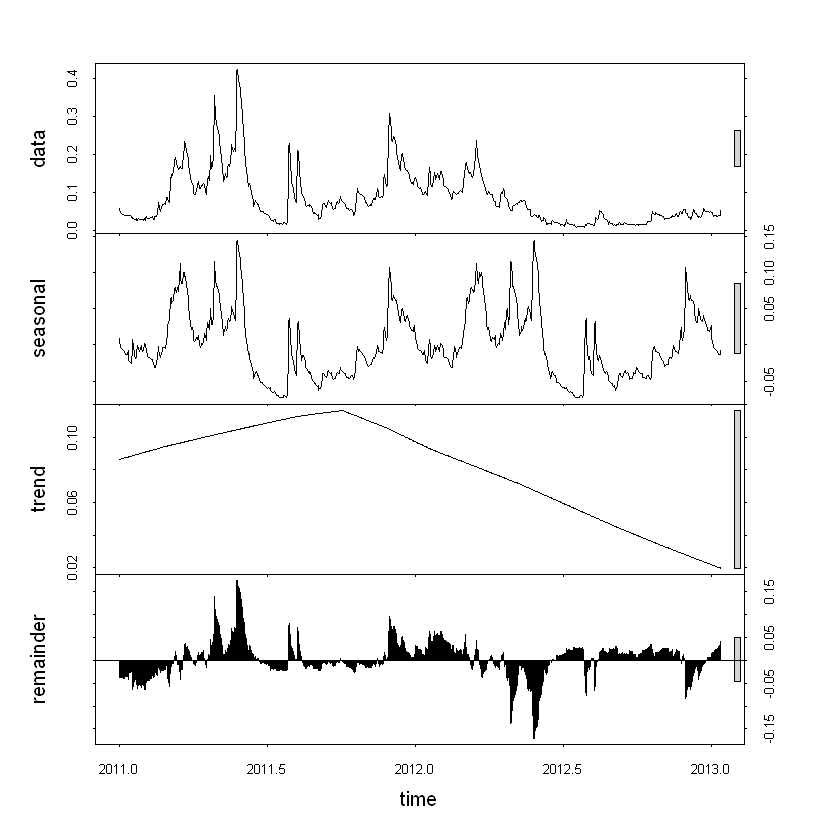

In [29]:
eri02 <- data_runoff %>% filter(lake == 'eri' & subbasin == 2) %>% select(date, runoff)
runoff_ts <- ts(eri02$runoff, start=c(2011,1), end=c(2013,12), frequency=365)
decomp = stl(runoff_ts, s.window="periodic")
deseasonal_cnt <- seasadj(decomp)
plot(decomp)

In [30]:
adf.test(runoff_ts, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  runoff_ts
Dickey-Fuller = -3.9711, Lag order = 9, p-value = 0.01044
alternative hypothesis: stationary


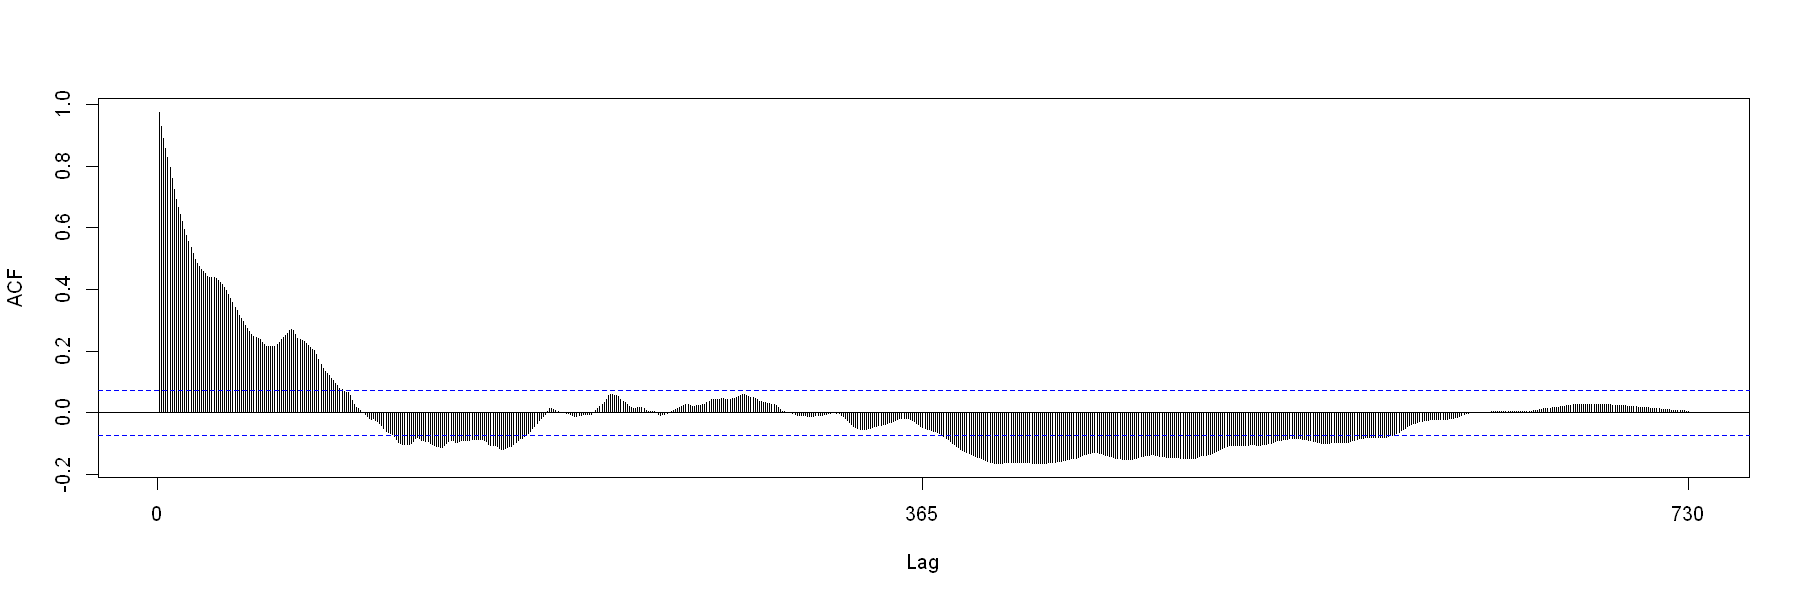

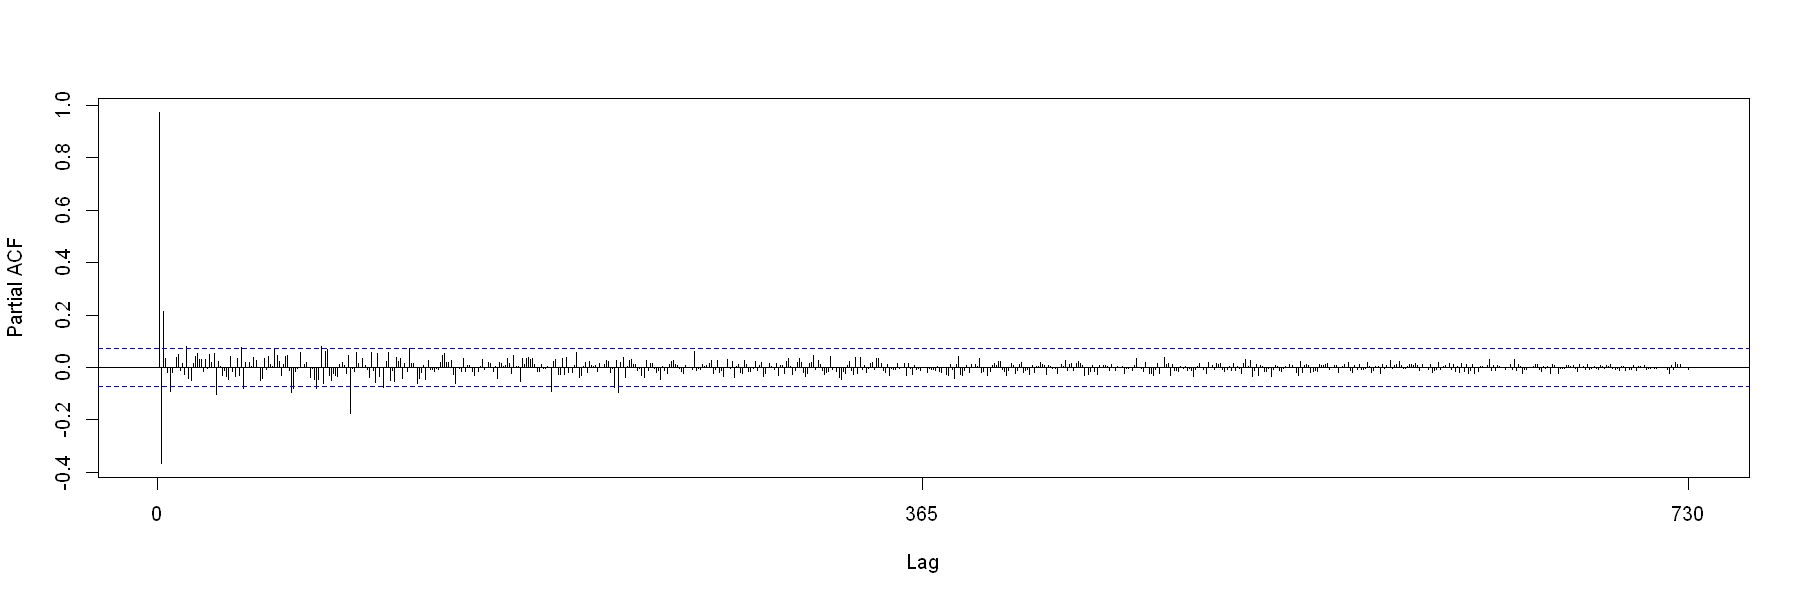

In [31]:
saved <- options(repr.plot.width=15, repr.plot.height=5)
Acf(runoff_ts, main='')
Pacf(runoff_ts, main='')
options(saved)

[1] "MSE: 0.160226708563495"
[1] "MSE: 0.0792130341683822"
[1] "MSE: 0.083421324277691"


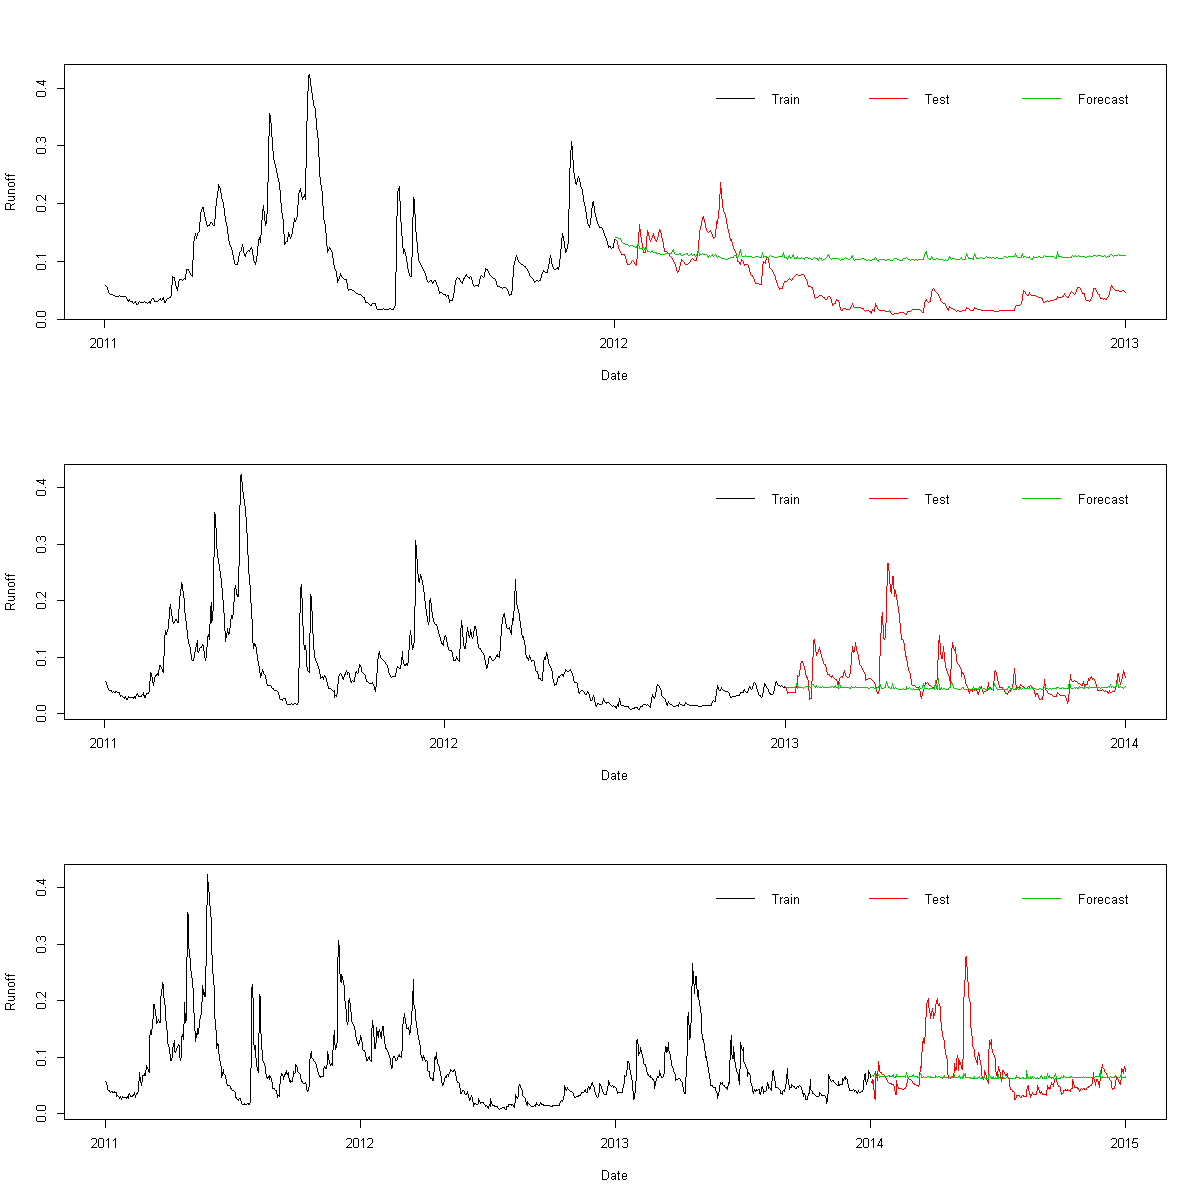

In [285]:
saved <- options(repr.plot.width=10, repr.plot.height=10)
data_with_runoff <- data %>% filter(lake == 'eri' & subbasin == 2) %>% filter(date >= ymd('2011-01-01') & date <= ymd('2014-12-31'))
cut_date <- ymd('2012-01-01')
par(mfrow=c(3,1))
for (i in 1:3) {
    train_y <- data_with_runoff %>% filter(date < cut_date) %>% select(runoff)
    train_xreg <- data_with_runoff %>% filter(date < cut_date) %>% select(tmin, tmax, prec)
    test_y <- data_with_runoff %>% filter(date >= cut_date & date < cut_date + years(1)) %>% select(runoff)
    test_xreg <- data_with_runoff %>% filter(date >= cut_date & date < cut_date + years(1)) %>% select(tmin, tmax, prec)

    fit <- auto.arima(train_y, xreg=as.matrix(train_xreg))
    fcast <- forecast(fit, h=length(test), xreg=as.matrix(test_xreg))

    mse <- sum((fcast[['mean']] - test_y[,1]) ^ 2) / length(fcast)
    print(paste('MSE:', mse))
    
    idx_start <- ymd('2011-01-01')
    plot(x=c(idx_start+days(index(train_y)), idx_start+days(index(test_y[,1])+length(train_y[,1]))), y=c(train_y[,1], rep(NA, length(test_y[,1]))), 
        type='l', xlab='Date', ylab='Runoff')
    lines(x=idx_start + days(index(test_y)+length(train_y[,1])), y=test_y[,1], col=2)
    lines(x=idx_start + days(index(test_y)+length(train_y[,1])), y=fcast[['mean']], col=3)
    legend("topright", legend=c("Train", "Test", "Forecast"), col=1:3, ncol=3, lty=1, bty='n')
    
    cut_date <- cut_date + years(1)
}
options(saved)